## Layered Value Iteration on the Pig Game

In [1]:
# we need this later for plotting

import plotly.io as pio
pio.renderers.default = 'notebook_connected'


In [2]:
# creating a function to run layered value iteration

import numpy as np

def pig_layered_value_iteration(target_score=100, die_sides=6, max_turn=100, epsilon=1e-6):
    roll_values = list(range(1, die_sides + 1)) # can use different size dice
    roll_prob = 1 / die_sides 
    MAX_TURN = max_turn # the max turn - I just set it to 100 so we don't have runaway recursion

    V = np.zeros((target_score + 1, target_score + 1, MAX_TURN + 1)) # initialise the values all as zeros
    policy = np.ones_like(V, dtype=int)  # start with an array of 1s to start (i.e., we roll all the time to begin with)

    # Set terminal states (ps = player score, os = opponent score, t = turn)
    for ps in range(target_score + 1):
        for os in range(target_score + 1):
            for t in range(MAX_TURN + 1):
                if ps + t >= target_score:
                    V[ps, os, t] = 1.0
                    policy[ps, os, t] = 0  # hold
                elif os >= target_score:
                    V[ps, os, t] = 0.0

    # Perform layered value iteration
    for score_sum in reversed(range(0, 2 * target_score)): # iterate over all possible scores
        converged = False # set the convergence to false to start with

        while not converged: 
            max_diff = 0

            for ps in range(max(0, score_sum - target_score + 1), min(target_score, score_sum + 1)): # iterate over all possible player scores
                os = score_sum - ps # opponent score is the total score minus player score
                if os >= target_score or ps >= target_score: # either player or opponent already won
                    continue

                for t in range(MAX_TURN + 1): # iterate over all possible turns
                    if os >= target_score:
                        continue  # opponent already won

                    # --- ROLL value --- # first calculate the value of rolling
                    roll_value = 0.0
                    for roll in roll_values:
                        if roll == 1:
                            roll_value += roll_prob * (1 - V[os, ps, 0]) # add value of rolling a 1 (which is the value of the opponent's new state taken straight from the value array)
                        else:
                            new_t = t + roll # add the value of all other rolls
                            if ps + new_t >= target_score:
                                roll_value += roll_prob * 1.0 # if we win, add 1.0 times probabiluity of that roll
                            elif new_t <= MAX_TURN:
                                roll_value += roll_prob * V[ps, os, new_t] # otherwise, justr add the value of the state we end up in multiplied by the probability of getting there

                    # --- HOLD value --- now, calculate the value of holding
                    if ps + t >= target_score:
                        hold_value = 1.0
                    elif os >= target_score:
                        hold_value = 0.0
                    #elif os >= target_score - die_sides:
                    #    hold_value = 0.0 
                    elif os + ps + t > score_sum:
                        hold_value = 1 - V[os, ps + t, 0] # flip the scores and extract from the Value array
                    else:
                        hold_value = 0.0

                    new_v = max(roll_value, hold_value)
                    new_policy = 1 if roll_value >= hold_value else 0  # 1 = roll, 0 = hold
                    diff = abs(V[ps, os, t] - new_v)

                    V[ps, os, t] = new_v
                    policy[ps, os, t] = new_policy

                    max_diff = max(max_diff, diff) # calculate the new max difference to know whether to stop

            if max_diff < epsilon:
                converged = True

    return V, policy


In [ ]:
# creating a function to plot our results as a decision surface
# only plots first time we move from roll to hold, and not any overhangs

import plotly.graph_objects as go

def plot_decision_surface_from_policy(policy, target_score=100, max_turn=100):
    Z = np.full((target_score, target_score), np.nan) # create a grid of NaNs to start with

    for ps in range(target_score):
        for os in range(target_score):
            for t in range(max_turn + 1):
                if policy[ps, os, t] == 0:  # 0 = hold
                    Z[ps, os] = t
                    break
            else:
                Z[ps, os] = max_turn + 1  # never holds

    X, Y = np.meshgrid(np.arange(target_score), np.arange(target_score), indexing='ij')

    fig = go.Figure(data=[go.Surface(
        z=Z,
        x=X,
        y=Y,
        colorscale='RdYlGn',
        colorbar=dict(title="Turn Total (Hold Threshold)")
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='Player Score',
            yaxis_title='Opponent Score',
            zaxis_title='Min Turn Total to Hold',
        ),
        title="Optimal Roll vs Hold Surface (0 = Hold, 1 = Roll)",
        width=900,
        height=750
    )

    fig.show()


In [104]:
# running the layered value iteration function

die_size = 6
target_score = 100
max_turn = 100
V, policy = pig_layered_value_iteration(target_score=target_score, die_sides=die_size, max_turn=max_turn, epsilon=1e-6)

In [ ]:
# plotting the decision surface (up to first hold)

plot_decision_surface_from_policy(policy, target_score=target_score, max_turn=max_turn)


In [11]:
# a scatter plot of the decision points, including overhangs

def plot_decision_points_from_policy(policy, target_score=100, max_turn=100):
    xs, ys, zs = [], [], []

    for ps in range(target_score):
        for os in range(target_score):
            for t in range(max_turn + 1):
                if policy[ps, os, t] == 1:  # 1 = roll
                    xs.append(ps)
                    ys.append(os)
                    zs.append(t)  # Record the turn total at which the decision is "roll"

    fig = go.Figure(data=[go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='markers',
        marker=dict(
            size=3,
            color=zs,  # Color based on turn total
            colorscale='RdYlGn',  # Perceptually uniform and colorblind-friendly
            opacity=0.7,
            colorbar=dict(title='Turn Total')  # Adds a colorbar legend
        )
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='Player Score',
            yaxis_title='Opponent Score',
            zaxis_title='Turn Total',
        ),
        title="Decision Points Where Action is 'Roll'",
        width=900,
        height=750
    )

    fig.show()



In [12]:
plot_decision_points_from_policy(policy, target_score=target_score, max_turn=max_turn)

## Recreating Figure 4 - Reachable States and Max Turn Scores

In [ ]:
# a function to find the max turn for each state

def find_max_turn(policy, target_score=100, max_turn=100):
    policy_30 = policy[:, 30, :]  # extract the policy for the opponent score of 30

    def process_row(row):
        if row[0] != 1:
            return 0  # Doesn't start with 1, sum is 0
        for idx in range(1, len(row)):
            if row[idx - 1] == 1 and row[idx] == 0:
                return np.sum(row[:idx])  # Cut at first 1 → 0 transition
        return np.sum(row)  # No 1 → 0 transition found


    # finds the state at which we first hold
    first_hold_values = np.apply_along_axis(process_row, 1, policy_30)

    # now want to add 5 to each of these, which is the max turn total
    max_turn_totals = first_hold_values + 5

    return max_turn_totals

In [ ]:
# a function to find the reachable states

def calculate_reachable_states(first_hold_values, die_size=6, target_score=100):
    reachable_states = [0]
    for state in range(target_score):
        if state in reachable_states:
            for i in range(1, die_size):  # can't roll a zero
                reachable_states.append(state + first_hold_values[state] + i)  # add the max turn total to the state
    Reachable_states =  sorted(list(set(np.array(reachable_states).flatten())))  # Remove duplicates and sort
    return [state for state in Reachable_states if state < target_score]

In [ ]:
# a function to create the list of values for plotting

def calculate_max_turns_plotting(max_turn_totals, target_score=100, Reachable_states=None):
    first_hold_values = max_turn_totals - 5  # subtract 5 to get the first hold values
    
    if Reachable_states is None:
        Reachable_states = calculate_reachable_states(first_hold_values, die_size=die_size, target_score=target_score)

    max_turns_plotting = []
    for state in range(target_score):
        if state in Reachable_states:
            max_turns_plotting.append(max_turn_totals[state])
        else:
            max_turns_plotting.append(0)  # Not reachable, set to 0
    return max_turns_plotting

In [167]:
# reproducing Figure 4

def Figure_4_plot(max_turn_totals, target_score=100):
    import matplotlib.pyplot as plt
    
    first_hold_values = max_turn_totals - 5  # subtract 5 to get the first hold values

    plt.figure(figsize=(10, 6))

    optimal_boundary = first_hold_values
    max_turns_plotting = calculate_max_turns_plotting(max_turn_totals, target_score=target_score, Reachable_states=calculate_reachable_states(first_hold_values, die_size=die_size, target_score=target_score))
    
    for i in range(target_score):
        max_turns_plotting[i] = min(max_turns_plotting[i], 100 - i)
    
    # Grey shaded area for Reachable States (like bars but filled region)
    plt.fill_between(
        range(target_score),
        0,
        max_turns_plotting,
        color='lightgrey',
        alpha=0.7,
        step='pre',
        label='Reachable'
    )

    # Horizontal Hold at 20 Line
    plt.axhline(
        y=20,
        color='grey',
        linestyle='--',
        linewidth=1.5,
        label='Hold at 20'
    )

    change_i = []  # Player Scores where a change happens
    change_k = []  # Corresponding Turn Totals

    policy_30 = policy[:, 30, :]  # Extract policy for opponent score of 30
    
    for i in range(policy_30.shape[0]):  # Loop over player scores
        row = policy_30[i]
        changes = np.where(np.diff(row) != 0)[0] + 1  # All changes (0→1 or 1→0)
        change_i.extend([i] * len(changes))  # Store current player score multiple times
        change_k.extend(changes)             # Store corresponding turn totals
    
    # Plot the valid points only
    plt.scatter(change_i, change_k, color='black', s=10, label='Optimal Boundary')

    # Styling
    plt.xlabel('Player 1 Score (i)')
    plt.ylabel('Turn Total (k)')
    plt.ylim(0, 50)
    plt.xlim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


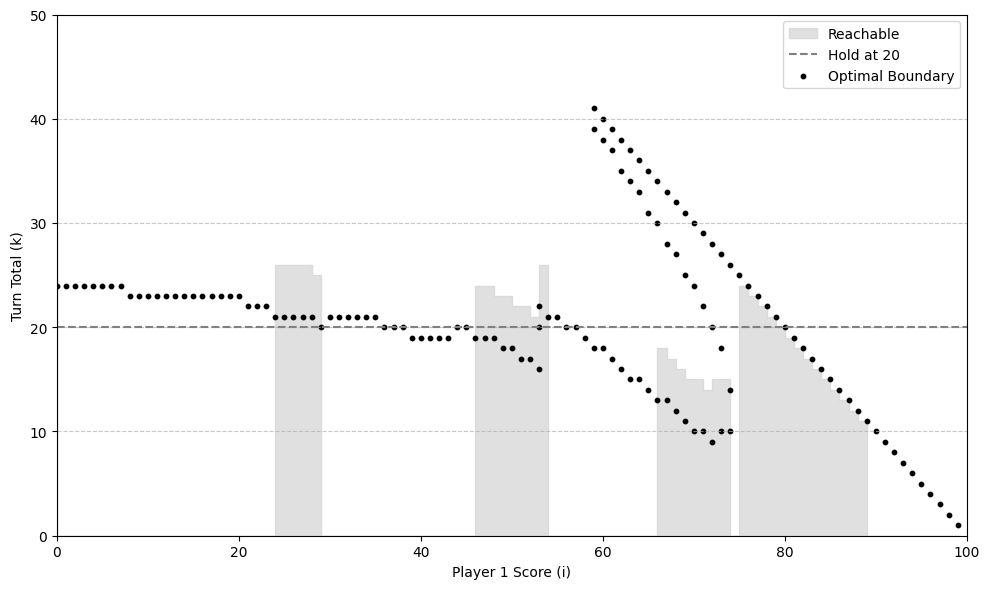

In [168]:
max_turn_totals = find_max_turn(policy, target_score=target_score, max_turn=max_turn)

Figure_4_plot(max_turn_totals, target_score=target_score)

In [ ]:
# am working on main - make a new branch before I start again